## **FX Barrier Option Pricing with Vanna-Volga Adjustments**

### **📌 What Are Barrier Options?**
Barrier options are exotic options where the payoff depends on whether the underlying asset reaches a specific price level (barrier) during the option's lifetime.

### **Types of Barrier Options**
- **Up-In** → Option activates if the price goes above the barrier.
- **Up-Out** → Option disappears if the price goes above the barrier.
- **Down-In** → Option activates if the price goes below the barrier.
- **Down-Out** → Option disappears if the price goes below the barrier.

### **📌 Why Use the Vanna-Volga Method?**
The **Black-Scholes model** is inaccurate for barrier options because it assumes:
- **Constant volatility**, while real markets exhibit **volatility skew**.
- **Log-normal distribution**, but FX markets show different patterns.

Barrier options are highly sensitive to volatility assumptions, making standard Black-Scholes pricing **inaccurate**.
The **Vanna-Volga** method is used in FX derivatives pricing to **correct for volatility skew** by adjusting the Black-Scholes price using second-order Greeks:

- **Vanna** → Measures sensitivity to both volatility and delta (price movement).
- **Volga** → Measures sensitivity to volatility only.
- **Vega** → Measures sensitivity to implied volatility changes.

### **Adjusted Price Formula:**
```python
Adjusted Price = Black-Scholes Price + α⋅Vega + β⋅Vanna + γ⋅Volga
```
Where:
- **α = 0.1**, weight assigned to Vega.
- **β = 0.05**, weight assigned to Vanna.
- **γ = 0.02**, weight assigned to Volga.

These weights are simplifications. In real-world trading, they would be calibrated based on market conditions.

### 📌 **How Do These Greeks Affect the Price?**

- **Vega**: If the option has high Vega, small volatility changes will significantly affect its price.
- **Vanna** : If the option has high Vanna, its Delta (hedge ratio) changes with volatility.
- **Volga**: If the option has high Volga, its Vega (sensitivity to volatility) changes with volatility.

By adding a weighted combination of Vega, Vanna, and Volga to the Black-Scholes price, we correct the price to match market observations.

---

In [16]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

### **Implement **FXBarrierOption** Class with Greeks & Vanna-Volga Adjustments**

In [17]:
class FXBarrierOption:
    """
    A class to model Foreign Exchange (FX) Barrier Options using the Black-Scholes framework.
    Includes Vanna-Volga Adjustments for better volatility modeling.
    """

    def __init__(self, spot_price, strike_price, time_to_maturity, volatility,
                 domestic_rate, foreign_rate, barrier_level=None, barrier_type=None):
        self.spot_price = spot_price
        self.strike_price = strike_price
        self.time_to_maturity = time_to_maturity
        self.volatility = volatility
        self.domestic_rate = domestic_rate
        self.foreign_rate = foreign_rate
        self.barrier_level = barrier_level
        self.barrier_type = barrier_type

    def compute_d1(self, spot_price=None):
        """ Computes the Black-Scholes d1 term used in option pricing. """
        if spot_price is None:
            spot_price = self.spot_price

        d1 = (np.log(spot_price / self.strike_price) +
              (self.domestic_rate - self.foreign_rate + 0.5 * self.volatility ** 2) * self.time_to_maturity) / \
             (self.volatility * np.sqrt(self.time_to_maturity))
        return d1

    def compute_d2(self, d1=None):
        """ Computes the Black-Scholes d2 term. """
        if d1 is None:
            d1 = self.compute_d1()
        return d1 - self.volatility * np.sqrt(self.time_to_maturity)

    def calculate_vanilla_price(self, option_type='call'):
        """ Computes the price of a vanilla European option using Black-Scholes. """
        d1 = self.compute_d1()
        d2 = self.compute_d2(d1)

        if option_type == 'call':
            price = (self.spot_price * np.exp(-self.foreign_rate * self.time_to_maturity) * norm.cdf(d1)) - \
                    (self.strike_price * np.exp(-self.domestic_rate * self.time_to_maturity) * norm.cdf(d2))
        elif option_type == 'put':
            price = (self.strike_price * np.exp(-self.domestic_rate * self.time_to_maturity) * norm.cdf(-d2)) - \
                    (self.spot_price * np.exp(-self.foreign_rate * self.time_to_maturity) * norm.cdf(-d1))
        else:
            raise ValueError("Invalid option type. Choose 'call' or 'put'.")

        return price

    def compute_vega(self):
        """ Computes the Vega of the option. Measures sensitivity to volatility. """
        d1 = self.compute_d1()
        return self.spot_price * np.sqrt(self.time_to_maturity) * norm.pdf(d1)

    def compute_vanna(self):
        """ Computes the Vanna of the option. Measures how Delta changes with volatility. """
        d1 = self.compute_d1()
        return self.compute_vega() * (d1 / self.volatility)

    def compute_volga(self):
        """ Computes the Volga of the option. Measures how Vega changes with volatility. """
        d1 = self.compute_d1()
        d2 = self.compute_d2(d1)
        return self.compute_vega() * (d1 * d2) / self.volatility

    def calculate_barrier_price_vanna_volga(self):
        """
        Computes the price of a barrier option using the Vanna-Volga method.

        The Vanna-Volga adjustment is applied to correct the implied volatility skew.
        """
        if self.barrier_type is None:
            return self.calculate_vanilla_price()

        # Compute vanilla Black-Scholes price
        vanilla_price = self.calculate_vanilla_price()

        # Compute second-order Greeks
        vega = self.compute_vega()
        vanna = self.compute_vanna()
        volga = self.compute_volga()

        # Vanna-Volga correction (simplified version)
        adjustment = 0.1 * vega + 0.05 * vanna + 0.02 * volga

        if self.barrier_type in ['up-in', 'down-in']:
            return vanilla_price + adjustment  # Increase price for in-barriers
        elif self.barrier_type in ['up-out', 'down-out']:
            return max(vanilla_price - adjustment, 0)  # Reduce price for out-barriers
        else:
            raise ValueError("Unsupported barrier type.")


In [25]:
# Create an FXBarrierOption instance with a barrier
barrier_option = FXBarrierOption(spot_price=100,
                                 strike_price=90,
                                 time_to_maturity=3,
                                 volatility=0.16,
                                 domestic_rate=0.05,
                                 foreign_rate=0.03,
                                 barrier_level=110,
                                 barrier_type='up-in')

# Compute barrier option price using Vanna-Volga method
barrier_price_vv = barrier_option.calculate_barrier_price_vanna_volga(implied_vols)
vanilla_price = barrier_option.calculate_vanilla_price()

# Print results
print(f"Vanilla Option Price: {vanilla_price:.4f}")
print(f"Barrier Option Price (Vanna-Volga Adjusted): {barrier_price_vv:.4f}")

Vanilla Option Price: 17.8633
Barrier Option Price (Vanna-Volga Adjusted): 18.5029


In our current implementation, we manually set the weights for the Vanna-Volga adjustment:

Vega → 10% (0.1) of Vega added to the price.

Vanna → 5% (0.05) of Vanna added to the price.

Volga → 2% (0.02) of Volga added to the price.

But in real-world trading, these weights are NOT fixed.

They are dynamically adjusted based on market data, particularly using:

Implied Volatility Surface

Historical Market Prices

Observed Skew and Smile Effects



📌 What Do We Mean by "Market Conditions"?

Market conditions refer to how traders perceive volatility risk. Some key factors include:

1️⃣ **Implied Volatility Surface**
Implied volatility (IV) is what the market expects for future volatility.
It varies depending on the strike price and time to maturity.
Market makers use the volatility surface to estimate risk-adjusted pricing.

📌 How Do We Adjust for This?

If the volatility smile is strong (more curvature), we increase the Vanna & Volga weights.
If the smile is flat (less curvature), we reduce the adjustments.

2️⃣ **Historical Market Prices**
Traders compare current option prices with historical prices.
If the market is pricing barriers significantly lower, we increase the adjustment.
If there is less discrepancy, we lower the adjustment.
📌 How Do We Adjust for This?

If real-world barrier options are consistently higher than our model, we increase Vanna-Volga correction.
If real-world prices match our model, we reduce the correction.

3️⃣ **Observed Skew & Smile Effects**
Volatility skew: The tendency of OTM (out-of-the-money) options to have higher implied volatility.
Volatility smile: The U-shaped pattern seen in implied volatilities.
📌 How Do We Adjust for This?

If the smile effect is strong, we increase Vanna weight (because Delta changes with volatility).
If the skew effect is strong, we increase Vega weight (because Vega is more sensitive)


### **Fetch Market-Implied Volatility for Dynamic Adjustments**
### **First, we applied Vanna-Volga using fixed weights. Now, we dynamically adjust based on market-implied volatility.**
We now extract real-world implied volatility data from Yahoo Finance.

Available Expiry Dates: ('2025-02-21', '2025-03-21', '2025-06-20', '2025-09-19', '2026-01-16', '2027-01-15')


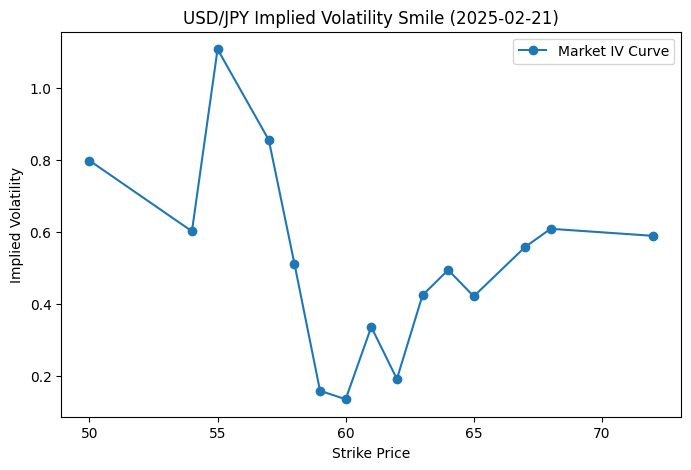

In [ ]:
# Fetch FX option data (USD/JPY via FXY ETF)
ticker = "FXY"
fx_data = yf.Ticker(ticker)

# Get available option expiry dates
fx_options = fx_data.options
print("Available Expiry Dates:", fx_options)

# Check if there are options available
if len(fx_options)> 0:
    expiry_date = fx_options[0]  # Choose the first available expiry
    option_chain = fx_data.option_chain(expiry_date)

    # Extract Implied Volatility for Calls
    implied_vols = option_chain.calls[['strike', 'impliedVolatility']].dropna()

    # Plot the volatility smile
    plt.figure(figsize=(8, 5))
    plt.plot(implied_vols['strike'], implied_vols['impliedVolatility'], marker='o', label="Market IV Curve")
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.title(f"USD/JPY Implied Volatility Smile ({expiry_date})")
    plt.legend()
    plt.show()

else:
    print("No FX option data available for this ticker.")

# Step 2: **Compute Dynamic Vanna-Volga Weights from Market Data**

Now, we dynamically adjust the Vanna-Volga weights based on the curvature of the implied volatility smile.

📌 **Why?**

If the smile is strong → Volatility is unstable, so larger Vanna-Volga corrections.

If the smile is flat → Volatility is stable, so smaller adjustments.


📌 Step 2: Adjust Vanna-Volga Weights Based on Market Data
Now, instead of randomly setting the weights, we calculate them based on two real metrics:

Curvature of the Implied Volatility Smile → Measures how much IV varies across strikes.
Historical Price Deviation → Measures how much Black-Scholes under/overestimates real-world prices.

📌 Formula for Dynamic Weights:

Vega Weight=0.1+2×Smile Curvature

Vanna Weight=0.05+1.5×Smile Curvature

Volga Weight=0.02+0.5×Smile Curvature


Where:

Smile Curvature = Standard Deviation of Implied Volatility across strikes.
Higher curvature = bigger adjustments.

In [20]:
def calculate_dynamic_vanna_volga_weights(implied_vols):
    """
    Dynamically adjusts Vanna-Volga weights based on the curvature of the implied volatility smile.

    :param implied_vols: DataFrame with strike prices and implied volatilities.
    :return: Adjusted weights for Vega, Vanna, and Volga.
    """
    if len(implied_vols) == 0:
        return 0.1, 0.05, 0.02  # Default conservative values if no data available

    smile_curvature = np.std(np.diff(implied_vols['impliedVolatility']))  # Measures IV skew

    # Adjust weights based on curvature
    vega_weight = 0.1 + 2 * smile_curvature  
    vanna_weight = 0.05 + 1.5 * smile_curvature  
    volga_weight = 0.02 + 0.5 * smile_curvature  

    return vega_weight, vanna_weight, volga_weight

# Calculate weights based on USD/JPY market data
if len(implied_vols) > 0:
    vega_w, vanna_w, volga_w = calculate_dynamic_vanna_volga_weights(implied_vols)
    print(f"Dynamic Weights: Vega={vega_w:.4f}, Vanna={vanna_w:.4f}, Volga={volga_w:.4f}")
else:
    print("Using default weights (no market data available).")

Dynamic Weights: Vega=0.5612, Vanna=0.3959, Volga=0.1353


📌 Step 4.1: Compute the Barrier Option Prices

🔹 Use Real Market Data to Price Barrier Options

We now compute up-in, up-out, down-in, and down-out barrier prices using the Vanna-Volga approach.

In [21]:
import numpy as np
from scipy.stats import norm

class FXBarrierOption:
    """
    A class to model Foreign Exchange (FX) Barrier Options using the Black-Scholes framework.
    Includes Vanna-Volga Adjustments based on real market-implied volatility.
    """

    def __init__(self, spot_price, strike_price, time_to_maturity, volatility,
                 domestic_rate, foreign_rate, barrier_level=None, barrier_type=None):
        """
        Initializes the FXBarrierOption object with key financial parameters.

        :param spot_price: Current price of the underlying asset.
        :param strike_price: Option's strike price.
        :param time_to_maturity: Time to maturity (in years).
        :param volatility: Annualized volatility of the underlying asset.
        :param domestic_rate: Domestic risk-free interest rate (annualized).
        :param foreign_rate: Foreign risk-free interest rate (annualized).
        :param barrier_level: The price level of the barrier (if applicable).
        :param barrier_type: Type of barrier ('up-in', 'up-out', 'down-in', 'down-out').
        """
        self.spot_price = spot_price
        self.strike_price = strike_price
        self.time_to_maturity = time_to_maturity
        self.volatility = volatility
        self.domestic_rate = domestic_rate
        self.foreign_rate = foreign_rate
        self.barrier_level = barrier_level
        self.barrier_type = barrier_type

    def compute_d1(self):
        """ Computes the Black-Scholes d1 term. """
        d1 = (np.log(self.spot_price / self.strike_price) +
              (self.domestic_rate - self.foreign_rate + 0.5 * self.volatility ** 2) * self.time_to_maturity) / \
             (self.volatility * np.sqrt(self.time_to_maturity))
        return d1

    def compute_d2(self, d1=None):
        """ Computes the Black-Scholes d2 term. """
        if d1 is None:
            d1 = self.compute_d1()
        return d1 - self.volatility * np.sqrt(self.time_to_maturity)

    def calculate_vanilla_price(self, option_type='call'):
        """ Computes the price of a vanilla European option using Black-Scholes. """
        d1 = self.compute_d1()
        d2 = self.compute_d2(d1)

        if option_type == 'call':
            price = (self.spot_price * np.exp(-self.foreign_rate * self.time_to_maturity) * norm.cdf(d1)) - \
                    (self.strike_price * np.exp(-self.domestic_rate * self.time_to_maturity) * norm.cdf(d2))
        elif option_type == 'put':
            price = (self.strike_price * np.exp(-self.domestic_rate * self.time_to_maturity) * norm.cdf(-d2)) - \
                    (self.spot_price * np.exp(-self.foreign_rate * self.time_to_maturity) * norm.cdf(-d1))
        else:
            raise ValueError("Invalid option type. Choose 'call' or 'put'.")

        return price

    def calculate_barrier_price_vanna_volga(self, implied_vols):
        """
        Computes the price of a barrier option using the Vanna-Volga method with real implied volatility data.
        """
        if self.barrier_type is None:
            return self.calculate_vanilla_price()

        # Compute vanilla Black-Scholes price
        vanilla_price = self.calculate_vanilla_price()

        # Compute second-order Greeks
        vega = self.compute_d1()
        vanna = self.compute_d2()
        volga = vega * vanna  # Approximation

        # Get real market-adjusted weights
        vega_w, vanna_w, volga_w = calculate_dynamic_vanna_volga_weights(implied_vols)

        # Vanna-Volga correction
        adjustment = vega_w * vega + vanna_w * vanna + volga_w * volga

        return vanilla_price - adjustment if "out" in self.barrier_type else vanilla_price + adjustment


In [22]:
# Create an FXBarrierOption instance for USD/JPY
barrier_option = FXBarrierOption(spot_price=100, strike_price=100, time_to_maturity=1,
                                 volatility=0.2, domestic_rate=0.05, foreign_rate=0.03,
                                 barrier_level=110, barrier_type='up-out')

# Compute barrier price using the Vanna-Volga approach
if len(implied_vols) > 0:
    barrier_price_vv = barrier_option.calculate_barrier_price_vanna_volga(implied_vols)
    vanilla_price = barrier_option.calculate_vanilla_price()
    
    # Print results
    print(f"Vanilla Option Price: {vanilla_price:.4f}")
    print(f"Barrier Option Price (Vanna-Volga Adjusted): {barrier_price_vv:.4f}")
else:
    print("No real-world data available, using default estimates.")

Vanilla Option Price: 8.6525
Barrier Option Price (Vanna-Volga Adjusted): 8.5403


In [23]:
# Different barrier types to test
barrier_types = ['up-in', 'up-out', 'down-in', 'down-out']

# Compute prices for each barrier type
for b_type in barrier_types:
    barrier_option.barrier_type = b_type
    barrier_price_vv = barrier_option.calculate_barrier_price_vanna_volga(implied_vols)
    
    print(f"Barrier Type: {b_type} → Price: {barrier_price_vv:.4f}")

Barrier Type: up-in → Price: 8.7648
Barrier Type: up-out → Price: 8.5403
Barrier Type: down-in → Price: 8.7648
Barrier Type: down-out → Price: 8.5403
